We consider the speed of the particles high enough to neglect the influence of the electromagnetic repulsion force between the two coliding particle, and therefore they will colide as rigid spheres.

In high-energy nuclear physics — specifically, in colliding-beam experiments — collisions may be classified according to their impact parameter. Central collisions have � ≈ 0 {\displaystyle b\approx 0}, peripheral collisions have 0 < � < 2 � {\displaystyle 0<b<2R}, and ultraperipheral collisions (UPCs) have � > 2 � {\displaystyle b>2R}, where the colliding nuclei are viewed as hard spheres with radius � R.[2] Because the color force has an extremely short range, it cannot couple quarks that are separated by much more than one nucleon's radius; hence, strong interactions are suppressed in peripheral and ultraperipheral collisions. This means that final-state particle multiplicity (the total number of particles resulting from the collision), is typically greatest in the most central collisions, due to the partons involved having the greatest probability of interacting in some way. This has led to charged particle multiplicity being used as a common measure of collision centrality, as charged particles are much easier to detect than uncharged particles.[5] Because strong interactions are effectively impossible in ultraperipheral collisions, they may be used to study electromagnetic interactions — i.e. photon–photon, photon–nucleon, or photon–nucleus interactions — with low background contamination. Because UPCs typically produce only two to four final-state particles, they are also relatively "clean" when compared to central collisions, which may produce hundreds of particles per event. https://en.wikipedia.org/wiki/Impact_parameter

Documentation:

https://en.wikipedia.org/wiki/Impact_parameter
https://en.wikipedia.org/wiki/Distance_of_closest_approach
https://en.wikipedia.org/wiki/Elastic_collision

Multivariate normal distribution (we can change the aplitudes in x,y,z for the initial gaussian distribution for the beam to take into account the relativistic motion)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
from matplotlib import animation
from IPython import display
from matplotlib.animation import PillowWriter

from mpl_toolkits.mplot3d import Axes3D
# %matplotlib widget


In [2]:
def loc_vel_assigner(Natoms):
    color_array = []
    Atoms = np.zeros(Natoms)
    apos = np.zeros((Natoms,3))
    p = np.zeros((Natoms,3))
    for i in range(Natoms):
        Atoms[i] = i
        x = np.random.normal(loc = 0.0, scale = 2*Rbeam)
        y = np.random.normal(loc = 0.0, scale = Rbeam)
        z = np.random.normal(loc = 0.0, scale = Rbeam)
        if Atoms[i] < Natoms/2:
            color_array.append('b')
            apos[i] = np.array([x-L,y,z])
            px = 1
            py = 0
            pz = 0
            p[i] =  np.array([px,py,pz])
        else:
            color_array.append('r')
            apos[i] = np.array([x+L,y,z])
            px = -1
            py = 0
            pz = 0
            p[i] =  np.array([px,py,pz])
    return Atoms, apos, p, color_array


In [3]:
def checkCollisions(apos,Natoms,Ratom):
    hitlist = []
    r2 = 2*Ratom
    for i in range(Natoms):
        ai = apos[i]
        for j in range(i) :
            aj = apos[j]
            dr = ai - aj
            if np.linalg.norm(dr) < r2: hitlist.append([i,j])
    return np.array(hitlist)


In [4]:
def colision_resolver(i, j, apos, p, color_array):
    ptot = p[i]+p[j]
    pos_i = apos[i]
    pos_j = apos[j]
    vi = p[i]/mass
    vj = p[j]/mass
    vrel = vj-vi
    rrel = pos_i-pos_j
    # first we move the particles to the colision point 
    # theta is the angle between vrel and rrel:
    dx = np.dot(rrel, vrel/np.linalg.norm(vrel))       # rrel.mag*cos(theta)
    dy = np.linalg.norm(np.cross(rrel, vrel/np.linalg.norm(vrel))) # rrel.mag*sin(theta)
    # alpha is the angle of the triangle composed of rrel, path of atom j, and a line
    #   from the center of atom i to the center of atom j where atome j hits atom i:
    alpha = np.arcsin(dy/(2*Ratom)) 
    d = (2*Ratom)*np.cos(alpha)-dx # distance traveled into the atom from first contact
    deltat = d/np.linalg.norm(vrel)         # time spent moving from first contact to position inside atom
    pos_i = pos_i-vi*deltat # back up to contact configuration
    pos_j = pos_j-vj*deltat
    # now we can calculate the direction and magnitude of the new velocity
    mtot = 2*mass
    pcmi = p[i]-ptot*mass/mtot # transform momenta to cm frame
    pcmj = p[j]-ptot*mass/mtot
    rrel = rrel/np.linalg.norm(rrel)
    pcmi = pcmi-2*np.dot(pcmi, rrel)*rrel # bounce in cm frame
    pcmj = pcmj-2*np.dot(pcmj, rrel)*rrel
    p[i] = pcmi + ptot*mass/mtot
    p[j] = pcmj + ptot*mass/mtot
    # move forward deltat in time to match the time we have skipped
    apos[i] = pos_i+(p[i]/mass)*deltat 
    apos[j] = pos_j+(p[j]/mass)*deltat
    color_array[i] = 'cyan'
    color_array[j] = 'yellow'
    return apos, p, color_array

In [5]:
def pos_update(apos, p, color_array):
    for i in range(Natoms): 
        apos[i] = apos[i] + (p[i]/mass)*dt
    for index in particle_track:
        particle_trajectory.append([apos[int(index)].tolist(),int(index)])
    hitlist = checkCollisions(apos,Natoms,Ratom)
    for ij in hitlist:
        i = ij[0]
        j = ij[1]
        vrel = (p[j]-p[i])/mass
        rrel = apos[i]-apos[j]
        if np.linalg.norm(vrel)**2 == 0: continue; 
        if np.linalg.norm(rrel) > Ratom: continue 
        print('Collision!')
        particle_track.append(i)
        particle_track.append(j)
        particle_trajectory.append([apos[i].tolist(),i])
        particle_trajectory.append([apos[j].tolist(),j])
        apos, p, color_array  = colision_resolver(i, j, apos, p, color_array) 
        particle_trajectory.append([apos[i].tolist(),i])
        particle_trajectory.append([apos[j].tolist(),j])
    return apos, p, color_array

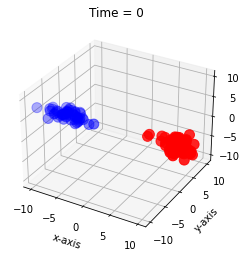

Collision!
Collision!
Collision!
Collision!


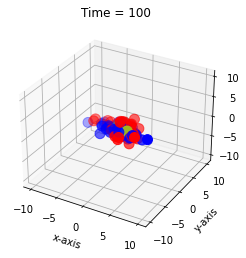

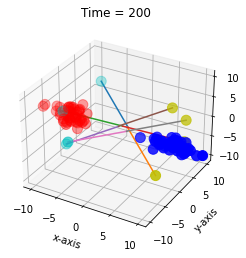

Solve took 3.77215 seconds


In [6]:
t0 = time.time()
Natoms = 100

Rbeam = 1
L = 10

# mass = (4/6)*10**(-26) # helium mass
mass = 1
Ratom = 0.1 # wildly exaggerated size of helium atom
# dt = 10**(-5)
dt = 0.1

Atoms, apos, p, color_array = loc_vel_assigner(Natoms)

figg = plt.figure()
ax = figg.add_subplot(111, projection='3d')
plot_geeks = ax.scatter(apos[:,0], apos[:,1], apos[:,2], marker='o', s = Ratom*10**3, color = color_array)
ax.set_title("Time = 0")
ax.set_xlabel('x-axis')
ax.set_ylabel('y-axis')
ax.set_zlabel('z-axis')
ax.axes.set_xlim3d(left = -(L+Rbeam), right = (L+Rbeam)) 
ax.axes.set_ylim3d(bottom = -(L+Rbeam), top = (L+Rbeam))
ax.axes.set_zlim3d(bottom = -(L+Rbeam), top = (L+Rbeam))
plt.show()

#Delete the particles that where colidining since the begining
hitlist = checkCollisions(apos,Natoms,Ratom)

if len(hitlist) > 0:
    apos = np.delete(apos, hitlist[:,0], 0) 
    color_array = np.delete(color_array, hitlist[:,0]) 
    p = np.delete(p, hitlist[:,0], 0) 
    Natoms = Natoms-len(hitlist)

particle_track = []
particle_trajectory = []

T = 200

for t in range(T):
    apos, p, color_array = pos_update(apos, p, color_array)
    if t == 100:
        trajectories = {i:[] for i in particle_track}
        for i in particle_trajectory: trajectories[i[1]].append(i[0])

        figg = plt.figure()
        ax = figg.add_subplot(111, projection='3d')
        plot_geeks = ax.scatter(apos[:,0], apos[:,1], apos[:,2], marker='o', s = Ratom*10**3, color = color_array)
        for index in particle_track:
            ax.plot([item[0] for item in trajectories[index]], [item[1] for item in trajectories[index]], [item[2] for item in trajectories[index]])
        ax.set_title("Time = 100")
        ax.set_xlabel('x-axis')
        ax.set_ylabel('y-axis')
        ax.set_zlabel('z-axis')
        ax.axes.set_xlim3d(left = -(L+Rbeam), right = (L+Rbeam)) 
        ax.axes.set_ylim3d(bottom = -(L+Rbeam), top = (L+Rbeam))
        ax.axes.set_zlim3d(bottom = -(L+Rbeam), top = (L+Rbeam))
        plt.show()
        

# Save all the trajectories for the coliding particles
trajectories = {i:[] for i in particle_track}
for i in particle_trajectory: trajectories[i[1]].append(i[0])

figg = plt.figure()
ax = figg.add_subplot(111, projection='3d')
plot_geeks = ax.scatter(apos[:,0], apos[:,1], apos[:,2], marker='o', s = Ratom*10**3, color = color_array)
for index in particle_track:
    ax.plot([item[0] for item in trajectories[index]], [item[1] for item in trajectories[index]], [item[2] for item in trajectories[index]])
ax.set_title("Time = 200")
ax.set_xlabel('x-axis')
ax.set_ylabel('y-axis')
ax.set_zlabel('z-axis')
ax.axes.set_xlim3d(left = -(L+Rbeam), right = (L+Rbeam)) 
ax.axes.set_ylim3d(bottom = -(L+Rbeam), top = (L+Rbeam))
ax.axes.set_zlim3d(bottom = -(L+Rbeam), top = (L+Rbeam))
plt.show()

print('Solve took %lg seconds' % (time.time()-t0,))


In [7]:
plt.close('all')

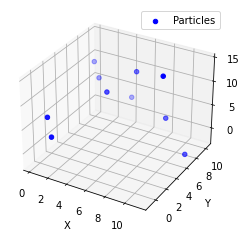

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

def initialize_particles(num_particles):
    positions = np.random.rand(num_particles, 3) * 10  # Random initial positions within a 10x10x10 cube
    velocities = np.random.rand(num_particles, 3) - 0.5  # Random initial velocities between -0.5 and 0.5
    charges = np.random.choice([-1, 1], num_particles)  # Random charges (-1 or 1)
    return positions, velocities, charges

def lorentz_force(q, v, B):
    return q * np.cross(v, B)

def update_particle(position, velocity, charge, dt, B):
    force = lorentz_force(charge, velocity, B)
    acceleration = force  # Assuming mass = 1
    velocity += acceleration * dt
    position += velocity * dt
    return position, velocity

def update(frame):
    ax.clear()
    for i in range(len(positions)):
        positions[i], velocities[i] = update_particle(positions[i], velocities[i], charges[i], dt, B)

    ax.scatter(positions[:, 0], positions[:, 1], positions[:, 2], c='b', marker='o', label='Particles')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.legend()

# Main simulation
num_particles = 10
positions, velocities, charges = initialize_particles(num_particles)
B = np.array([0, 0, 1])  # Example magnetic field vector (adjust as needed)
dt = 0.1  # Time step

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ani = FuncAnimation(fig, update, frames=100, interval=50, repeat=False)

# Save the animation or display it using plt.show()
# ani.save('particle_animation.gif', writer='imagemagick')
# plt.show()

# Display the animation using HTML
HTML(ani.to_jshtml())

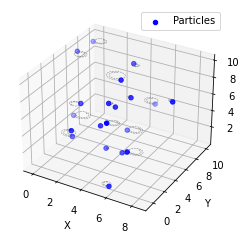

In [1]:
#code to show the particles with trajectory
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

def initialize_particles(num_particles):
    positions = np.random.rand(num_particles, 3) * 10  # Random initial positions within a 10x10x10 cube
    velocities = np.random.rand(num_particles, 3) - 0.5  # Random initial velocities between -0.5 and 0.5
    velocities[:, 1:] = 0  # Set y and z components to zero for velocity along x-axis
    charges = np.random.choice([-1, 1], num_particles)  # Random charges (-1 or 1)
    return positions, velocities, charges

def lorentz_force(q, v, B):
    return q * np.cross(v, B)

def update_particle(position, velocity, charge, dt, B):
    force = lorentz_force(charge, velocity, B)
    acceleration = force  # Assuming mass = 1
    velocity += acceleration * dt
    position += velocity * dt
    return position, velocity

#plotting the trajectory
def update(frame):
    ax.clear()
    for i in range(len(positions)):
        positions[i], velocities[i] = update_particle(positions[i], velocities[i], charges[i], dt, B)
        trajectories[i].append(positions[i].copy())  # Store the trajectory points

    ax.scatter(positions[:, 0], positions[:, 1], positions[:, 2], c='b', marker='o', label='Particles')
    for traj in trajectories:
        traj_array = np.array(traj)
        ax.plot(traj_array[:, 0], traj_array[:, 1], traj_array[:, 2], c='gray', linestyle='dashed', linewidth=0.5)
    
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.legend()

# Main simulation
num_particles = 20
positions, velocities, charges = initialize_particles(num_particles)
B = np.array([0, 0, 1])  # Example magnetic field vector (adjust as needed)
dt = 0.1  # Time step

trajectories = [[] for _ in range(num_particles)]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ani = FuncAnimation(fig, update, frames=100, interval=50, repeat=False)

# Display the animation using HTML
HTML(ani.to_jshtml())

In [5]:
lorentz_force(1, [5,2,5], [0,0,1])

array([ 2, -5,  0])